### ISyE524: Intro to Optimization
#### Problem Set #4
##### 1. Portfolio Optimization
###### 1-1

x^{+} is amounts bought for each asset.

x^{-} is amounts sold for each asset.

\begin{align*}
\text{Min} \quad & \sum_{i=1}^{225} (x_{i}^{+} + x_{i}^{-}) \\
\text{Subject to:} \quad & \sqrt{(h + x^{+} - x^{-} - b)^T Q (h + x^{+} - x^{-} - b)} \leq 10 \\
& x_{i}^{+} \geq 0 \quad \forall i \in (1, ... , 225) \\
& x_{i}^{-} \geq 0 \quad \forall i \in (1, ... , 225) \\
& x_{i}^{-} \leq h_{i} \quad \forall i \in (1, ... , 225) \\
& \sum_{i=1}^{225} h_{i} + x_{i}^{+} - x_{i}^{-} = 1 \\
\end{align*}

###### 1-2

In [11]:
using DataFrames, CSV, LinearAlgebra, NamedArrays

df = CSV.read("folio_mean.csv", DataFrame, header=false, delim=',')
(n,mmm) = size(df)

# Weekly numbers to annual, write as percentages (and flip returns to make more positive)
mu = -100/7*365*Vector(df[1:n,1])

df2 = CSV.read("folio_cov.csv",DataFrame,header=false,delim=',')

# Weekly numbers to annual, write as percentages, also reduce the risk a bit
Q = 0.5* (100/7*365)^2 * Matrix(df2) 

# Read the portfolio holding and benchmarks

df3 = CSV.read("folio_holding_benchmark.csv", DataFrame, header=false, delim=',')

h = Vector(df3[1:n,1])
b = Vector(df3[1:n,2])

# Current tracking risk 
benchmark_return = mu'b

# Current holdings return 
holdings_return = mu'*h 

# Current tracking risk 
active_risk = sqrt((h-b)'Q*(h-b))

println("Benchmark expected return: ", benchmark_return)
println("Holdings expected return: ", holdings_return)
println("Active Risk: ", active_risk)

Benchmark expected return: 9.48798378650461
Holdings expected return: 5.67073489826738
Active Risk: 32.909266412324


In [12]:
using JuMP, Gurobi, Statistics

# Define the model with the Ipopt solver
model = Model(Gurobi.Optimizer)
set_silent(model)

n = 225 # Number of assets

# Variables
@variable(model, x_p[1:n] >= 0) 
@variable(model, x_n[1:n] >= 0) 

# Objective: Minimize the transaction impact
@objective(model, Min, sum(x_p) + sum(x_n))

# Constraints
# Active risk constraint
@constraint(model, sum( (h[i] + x_p[i] - x_n[i] - b[i]) * Q[i,j] * (h[j] + x_p[j] - x_n[j] - b[j]) for i in 1:n for j in 1:n) <= 100)

# Full investment constraint
@constraint(model, sum(h[i] + x_p[i] - x_n[i] for i in 1:n) == 1)

# sell limit constraint
for i in 1:n
    @constraint(model, x_n[i] <= h[i])
end

# Solve the model
optimize!(model)

if termination_status(model) == MOI.OPTIMAL && primal_status(model) == MOI.FEASIBLE_POINT
    println("The model is solved and feasible.")
else
    println("The model is not solved or not feasible.")
end

optimal_x⁺ = value.(x_p)
optimal_x⁻ = value.(x_n)

# println("Optimal x⁺: ", optimal_x⁺)
# println("Optimal x⁻: ", optimal_x⁻)

total_transacted = sum(optimal_x⁺) + sum(optimal_x⁻) * 1e9
println("Total number of dollars transacted: ", total_transacted)

transactions = value.(x_p) .* 1e9  .+ value.(x_n) .* 1e9 
largest_transactions = sort(transactions, rev=true)[1:10]
average_largest_transactions = mean(largest_transactions)
println("The average size of the largest 10 transactions: ", average_largest_transactions)

# Calculate the expected return
new_holdings = h + value.(x_p) - value.(x_n)
expected_return = dot(mu, new_holdings) 
println("The portfolio expected return (%): ", expected_return)

# Calculate the active risk
active_risk_value = sqrt( sum( (h + value.(x_p) - value.(x_n) - b)' * Q * (h + value.(x_p) - value.(x_n) - b)) )
println("The portfolio active risk (%): ", active_risk_value)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
The model is solved and feasible.
Total number of dollars transacted: 5.465300906308948e8
The average size of the largest 10 transactions: 4.973213103713578e7
The portfolio expected return (%): 8.975405144720636
The portfolio active risk (%): 9.99999985629791


###### 1-3

y_{i} is the new holding of asset 

\begin{align*}
\text{Min} \quad & \sum_{i=1}^{225} y_{i}^{3/2} \\
\text{Subject to:} \quad & t_{i} \geq y_{i}^{3/2} \quad \forall i \in (1, ... , 225) \\
& \sqrt{(h + x^{+} - x^{-} - b)^T Q (h + x^{+} - x^{-} - b)} \leq 10 \\
& y_{i} = x_{i}^{+} + x_{i}^{-} \quad \forall i \in (1, ... , 225) \\
& x_{i}^{+} \geq 0 \quad \forall i \in (1, ... , 225) \\
& x_{i}^{-} \geq 0 \quad \forall i \in (1, ... , 225) \\
& x_{i}^{-} \leq h_{i} \quad \forall i \in (1, ... , 225) \\
& \sum_{i=1}^{225} h_{i} + x_{i}^{+} - x_{i}^{-} = 1 \\
\end{align*}

###### 1-4

In [13]:
using JuMP, LinearAlgebra, SCS, ECOS, HiGHS, Gurobi, Ipopt, Statistics

using JuMP, Gurobi, Statistics

# Define the model with the Ipopt solver
model = Model(Gurobi.Optimizer)
set_silent(model)

n = 225 # Number of assets

# Variables
@variable(model, x_p[1:n] >= 0) 
@variable(model, x_n[1:n] >= 0) 
@variable(model, y[1:n]) 

@variable(model, u[1:n] >= 0)
@variable(model, t1[1:n] >= 0)

for i in 1:n
    @constraint(model, [u[i], t1[i], y[i]] in RotatedSecondOrderCone())
    @constraint(model, [0.125, y[i], u[i]] in RotatedSecondOrderCone())
    @constraint(model, y[i] == x_p[i] + x_n[i])
end


# Objective: Minimize the transaction impact
@objective(model, Min, sum(t1))

# Constraints
# Active risk constraint
@constraint(model, sum( (h[i] + x_p[i] - x_n[i] - b[i]) * Q[i,j] * (h[j] + x_p[j] - x_n[j] - b[j]) for i in 1:n for j in 1:n) <= 100)

# Full investment constraint
@constraint(model, sum(h[i] + x_p[i] - x_n[i] for i in 1:n) == 1)

# sell limit constraint
for i in 1:n
    @constraint(model, x_n[i] <= h[i])
end

# Solve the model
optimize!(model)

if termination_status(model) == MOI.OPTIMAL && primal_status(model) == MOI.FEASIBLE_POINT
    println("The model is solved and feasible.")
else
    println("The model is not solved or not feasible.")
end

optimal_x⁺ = value.(x_p)
optimal_x⁻ = value.(x_n)

# println("Optimal x⁺: ", optimal_x⁺)
# println("Optimal x⁻: ", optimal_x⁻)

total_transacted = sum(optimal_x⁺) + sum(optimal_x⁻) * 1e9
println("Total number of dollars transacted: ", total_transacted)

transactions = value.(x_p) .* 1e9  .+ value.(x_n) .* 1e9 
largest_transactions = sort(transactions, rev=true)[1:10]
average_largest_transactions = mean(largest_transactions)
println("The average size of the largest 10 transactions: ", average_largest_transactions)

# Calculate the expected return
new_holdings = h + value.(x_p) - value.(x_n)
expected_return = dot(mu, new_holdings) 
println("The portfolio expected return (%): ", expected_return)

# Calculate the active risk
active_risk_value = sqrt( sum( (h + value.(x_p) - value.(x_n) - b)' * Q * (h + value.(x_p) - value.(x_n) - b)) )
println("The portfolio active risk (%): ", active_risk_value)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
The model is solved and feasible.
Total number of dollars transacted: 5.771997150770646e8
The average size of the largest 10 transactions: 4.592001826305032e7
The portfolio expected return (%): 8.85613893919552
The portfolio active risk (%): 9.999969376977607


##### 2. Making An Indefinite Matrix Definite
###### 2-1

In [3]:
using LinearAlgebra

# Define the matrix Q
Q = [
    0 0 -2 -4 0 1;
    0 1 -1 -1 3 -4;
    -2 -1 -1 -5 7 -4;
    -4 -1 -5 -3 7 -2;
    0 3 7 7 -1 -2;
    1 -4 -4 -2 -2 0
]

# Compute the eigenvalues and eigenvectors
eigenvalues = eigen(Q).values
# eigenvectors = eigen(Q).vectors
eigenvalues


6-element Vector{Float64}:
 -16.119094460644884
  -3.756648129364134
  -0.5922928569671964
   2.2331144580905455
   3.845741541835814
  10.389179447049864

###### 2-2

\begin{align*}
\text{Minimize} \quad & \sum_{i=1}^{6} D_{ii} \\
\text{Subject to:} \quad & x^{T}(Q+D)x≥0
\end{align*}

###### 2-3

In [4]:
using JuMP, SCS  
using LinearAlgebra

# Define the matrix Q
Q = [
    0 0 -2 -4 0 1;
    0 1 -1 -1 3 -4;
    -2 -1 -1 -5 7 -4;
    -4 -1 -5 -3 7 -2;
    0 3 7 7 -1 -2;
    1 -4 -4 -2 -2 0
]

# Create an optimization model
model = Model(SCS.Optimizer)  

# Add a variable for the diagonal matrix D
@variable(model, D[1:6] >= 0)

# The objective is to minimize the trace of D
@objective(model, Min, sum(D))

# Add the PSD constraint
@constraint(model, Q + Diagonal(D) in PSDCone())

# Solve the problem
optimize!(model)

# Check the solution status
status = termination_status(model)

if status == MOI.OPTIMAL
    # Fetch the optimal values of D
    optimal_D = value.(D)
    sum_optimal_D = sum(optimal_D)
    println("Optimal D: ", optimal_D)
    println("Sum of the diagonal elements of D: ", sum_optimal_D)
elseif status == MOI.INFEASIBLE
    println("The problem is infeasible.")
else
    println("The solver terminated with status: ", status)
end


------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 6, constraints m: 27
cones: 	  l: linear vars: 6
	  s: psd vars: 21, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 12, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.07e+01  3.37e+00  2.30e+02  9.47e+01  1.00e-01  1.23e-02 
   125| 6.91e-07  6.91e-07  5.93e-06  7.80e+01  1.00e-01  1.69e-02 
-------------------------------------------------

###### 2-4

\begin{aligned}
& \underset{X}{\text{minimize}}
& & \sum_{i=1}^{6}\sum_{j=1}^{6} |X_{ij}| \\
& \text{subject to}
& & Q + X \succeq 0, \\
&&& X = X^T.
\end{aligned}

###### 2-5

In [5]:
using JuMP, SCS, LinearAlgebra, PrettyTables

# Define the known Q matrix (you'll need to fill in the actual values of Q)
Q = [
    0 0 -2 -4 0 1;
    0 1 -1 -1 3 -4;
    -2 -1 -1 -5 7 -4;
    -4 -1 -5 -3 7 -2;
    0 3 7 7 -1 -2;
    1 -4 -4 -2 -2 0
]

# Create a model with the SCS solver
model = Model(SCS.Optimizer)

# Define the size of the matrix X
n = size(Q, 1)

# Define the variable for matrix X, ensuring it is symmetric
@variable(model, X[1:n, 1:n], Symmetric)

# Define auxiliary variables
@variable(model, Y[1:n, 1:n] >= 0)

# Add constraints to linearize the absolute value
for i in 1:n
    for j in 1:n
        @constraint(model, Y[i, j] >= X[i, j])
        @constraint(model, Y[i, j] >= -X[i, j])
    end
end

# objective function to use the auxiliary variables
@objective(model, Min, sum(Y[i, j] for i in 1:n for j in 1:n))

# Add the semidefinite constraint to the model
@constraint(model, Q + X in PSDCone())

# Solve the model
optimize!(model)

# Check the solution status
if termination_status(model) == MOI.OPTIMAL
    optimal_X = value.(X)
    println("Found optimal X:")
    pretty_table(optimal_X, header=string.(1:n), tf=tf_markdown)
else
    println("Could not find the optimal solution. Status: ", termination_status(model))
end

------------------------------------------------------------------
	       SCS v3.2.4 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 57, constraints m: 129
cones: 	  l: linear vars: 108
	  s: psd vars: 21, ssize: 1
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 201, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.25e+01  1.00e+00  3.14e+02 -1.30e+02  1.00e-01  1.70e-04 
   125| 8.96e-04  6.52e-05  3.84e-03  7.80e+01  1.00e-01  1.21e-03 
--------------------------------------------

##### 3. Checked Luggage

###### 3-1

weights: w1, ..., wn and limit W. 

volumns v1, ..., vn and limit V.

decision variables z1, ..., zn.

\begin{aligned}
{\text{Maximize}} \quad & \sum_{i=1}^{10} z_{i} \\
\text{Subject to:} \quad & \sum_{i=1}^{10} w_{i} z_{i} \leq W \\
\quad & z_i \in \{0,1\} \quad \forall i \in (1, ... 10)
\end{aligned}

###### 3-2

In [6]:
# parameters for our problem
w = [5, 6, 7, 6, 4, 6, 7, 3, 8, 5]  # weights
v = [2, 4, 5, 3, 3, 2, 3, 1, 2, 4]  # volumns
W = 30               # weight limit
V = 15               # volumn limit
n = length(w);        # number of items

using JuMP, HiGHS
m = Model(HiGHS.Optimizer)
set_silent(m)

@variable(m, z[1:n], Bin )
@constraint(m, sum( w[i]*z[i] for i=1:n) <= W )
@constraint(m, sum( v[i]*z[i] for i=1:n) <= V )
@objective(m, Max, sum( z[i] for i=1:n) )

optimize!(m)

println(termination_status(m))
println("z = ", value.(z) )
println("objective = ", objective_value(m) )

OPTIMAL
z = [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
objective = 6.0


###### 3-3

In [7]:
using JuMP, GLPK, PrettyTables

# parameters for our problem
w = [5, 6, 7, 6, 4, 6, 7, 3, 8, 5]  # weights
v = [2, 4, 5, 3, 3, 2, 3, 1, 2, 4]  # volumns
W = 30               # weight limit
V = 15               # volumn limit
n = length(w);        # number of items

M = zeros(V, W)

for volume_capacity in 1:V
    for weight_capacity in 1:W
        # Create a new model for each pair of constraints
        model = Model(GLPK.Optimizer)
        set_silent(model)

        @variable(model, x[1:n], Bin)
        @objective(model, Max, sum(x))

        @constraint(model, sum(w[i] * x[i] for i in 1:10) <= weight_capacity)
        @constraint(model, sum(v[i] * x[i] for i in 1:10) <= volume_capacity)
        optimize!(model)

        M[volume_capacity, weight_capacity] = objective_value(model)
    end
end

# results_matrix now contains the maximum number of items for each capacity constraint
pretty_table(M, tf=tf_markdown)

| Col. 1 | Col. 2 | Col. 3 | Col. 4 | Col. 5 | Col. 6 | Col. 7 | Col. 8 | Col. 9 | Col. 10 | Col. 11 | Col. 12 | Col. 13 | Col. 14 | Col. 15 | Col. 16 | Col. 17 | Col. 18 | Col. 19 | Col. 20 | Col. 21 | Col. 22 | Col. 23 | Col. 24 | Col. 25 | Col. 26 | Col. 27 | Col. 28 | Col. 29 | Col. 30 |
|--------|--------|--------|--------|--------|--------|--------|--------|--------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
|    0.0 |    0.0 |    1.0 |    1.0 |    1.0 |    1.0 |    1.0 |    1.0 |    1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |     1.0 |
|    0.0 |    0.0 |    1.0 |    1.0 |    1.0 |    1.0 |    1.0 |    1.0 |    1.0 |     1.0 |     1.0 |     1.0 |     1.0 

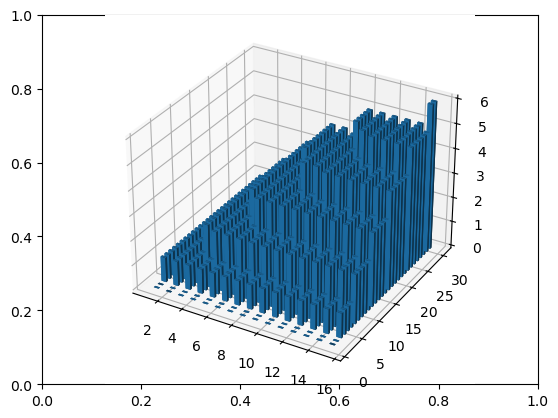

In [8]:
using PyPlot 

function plot3d(vals)
    nrows = size(vals,1)
    ncols = size(vals,2)
    _x = 1:nrows 
    _y = 1:ncols 
    # Make a meshgrid
    x = _x' .* ones(ncols)
    y = ones(nrows)' .* _y
    # Unravels
    x = vec(x)
    y = vec(y)
    # Heights

    dz = vec(vals')
    z = zeros(length(dz))

    dx = 0.4
    dy = 0.4

    # println("x: ", x)
    # println("y: ", y)
    # println("z: ", z)
    # println("dz: ", dz)
    
    bar3D(x,y,z,dx,dy,dz)
    display(gcf())
end

plot3d(M)

##### 4.  Steam Power
###### 4-1

x are tons of steam produced by boiler {B1, B2, B3}.

y are tons of steam produced by boiler {T1, T2, T3}.

\begin{aligned}
{\text{Minimize}} \quad & 10x_{1} + 8x_{2} + 7x_{3} + 2y_{1} + 3y_{2} + 4y_{3} \\
\text{Subject to:} \quad & 400 \leq x_{1} \leq 1000 \\
\quad & 200 \leq x_{2} \leq 900 \\
\quad & 300 \leq x_{3} \leq 800 \\
\quad & 300 \leq y_{1} \leq 600 \\
\quad & 500 \leq y_{2} \leq 800 \\
\quad & 600 \leq y_{3} \leq 900 \\
\quad & 4y_{1} + 5y_{2} + 6y_{3} \geq 8000 \\
\quad & y_{1} + y_{2} + y_{3} \leq x_{1} + x_{2} + x_{3} \\
\quad & x_{i}, y_{i} \in N^+ \quad \forall i \in (1, 2, 3)
\end{aligned}

###### 4-2

In [14]:
using JuMP, GLPK

# Model creation
model = Model(GLPK.Optimizer)

# Decision variables
@variable(model, 400 <= x1 <= 1000, Int)
@variable(model, 200 <= x2 <= 900, Int)
@variable(model, 300 <= x3 <= 800, Int)
@variable(model, 300 <= y1 <= 600, Int)
@variable(model, 500 <= y2 <= 800, Int)
@variable(model, 600 <= y3 <= 900, Int)

# Objective function
@objective(model, Min, 10x1 + 8x2 + 7x3 + 2y1 + 3y2 + 4y3)

# Constraints
@constraint(model, 4y1 + 5y2 + 6y3 >= 8000)  # Power production constraint
@constraint(model, y1 + y2 + y3 <= x1 + x2 + x3)  # Steam balance constraint

# Solve the problem
optimize!(model)

# Print the optimal solutions
println("x1: ", value(x1))
println("x2: ", value(x2))
println("x3: ", value(x3))
println("y1: ", value(y1))
println("y2: ", value(y2))
println("y3: ", value(y3))

# Print the objective value
println("Total cost: ", objective_value(model))

x1: 400.0
x2: 317.0
x3: 800.0
y1: 300.0
y2: 502.0
y3: 715.0
Total cost: 17102.0


##### 5. 524 Cheese
###### 5-1

• milk[t]: Pounds of milk to buy each week

• Sc[t]: Pounds of colby to sell each week

• Sm[t]: Pounds of mozerrella to sell each week

• Ic[t]: Inventory of colby at end of each each

• Im[t]: Inventory of mozerelaa at end of each week

• buy[t]: Indicator if whether or not milk was bought each week

\begin{aligned}
{\text{Maximize}} \quad & 2.5Sc_{t} + 3Sm_{t} - buy_{t}(p_t + f_t) - 0.25(Ic_t + Im_t) - 0.2milk_{t} \\
\text{Subject to:} \quad & Ic_t + Sc_{t} = Ic_{t-1} + 0.5 milk_{t} \quad \forall t \in (1, ..., 8) \\
\quad & Im_t + Sm_{t} = Im_{t-1} + 0.4 milk_{t} \quad \forall t \in (1, ..., 8) \\
\quad & Im_t + Ic_t \leq 500 \quad \forall t \in (1, ..., 8) \\
\quad & buy_{t} \leq M \times milk_{t} \quad \forall t \in (1, ..., 8) \\
\quad & Im_0 = 80 \\
\quad & Ic_0 = 120 \\
\quad & buy_{t} \in \{0,1\} \quad \forall i \in (1, ... 8) \\
\quad & Sc_{t}, Sm_{t}, milk_{t}, Ic_t, Im_t \in N^+ \quad \forall i \in (1, ... 8)
\end{aligned}



###### 5-2

In [21]:
# initial colby (pounds)
i_colby = 120 

# initial mozerella (pounds)
i_moz = 80 

# Demand for colby cheese (pounds)
d_colby = [150 200 225 50 400 50 300 200]
# Demand for mozerella cheese (pounds)
d_moz = [200 400 300 500 100 500 200 350]

# Fixed cost for a delivery of milk ($)
fc_milk = [1000 1400 800 1200 600 1000 400 800]

# Per-unit cost for milk ($/pound)
p_milk = [1 0.8 0.8 1.2 1.2 1.0 1.5 0.6]

# Processing cost of milk ($/pound)
milk_proc_cost = 0.2 

# inventory cost ($/pound) 
cheese_inventory_cost = 0.25

# max total inventory (pounds)
max_inventory = 500

# colby price ($/pound)
colby_price  = 2.5 

# mozzerella price ($/pound)
moz_price = 3.0 

# colby/milk
colby_per_milk = 0.5 

# moz/milk 
moz_per_milk = 0.4

# Number of time periods
T = 8

# The maximum milk you would buy in any period is surely no more than the total demand for cheese 
max_milk = [sum(d_colby[1:t])+sum(d_moz[1:t]) for t in 1:T]


8-element Vector{Int64}:
  350
  950
 1475
 2025
 2525
 3075
 3575
 4125

In [25]:
using JuMP, Gurobi

model = Model(Gurobi.Optimizer)

# Decision variables
@variable(model, milk[1:T] >= 0, Int)
@variable(model, Sc[1:T] >= 0, Int)
@variable(model, Sm[1:T] >= 0, Int)
@variable(model, Ic[1:T] >= 0, Int)
@variable(model, Im[1:T] >= 0, Int)
@variable(model, buy[1:T], Bin)

# Objective function
@objective(model, Max, sum(colby_price * Sc[t] + moz_price * Sm[t] - 
                           buy[t] * (p_milk[t] + fc_milk[t]) - 
                           cheese_inventory_cost * (Ic[t] + Im[t]) - 
                           milk_proc_cost * milk[t] for t in T))

# Constraints
for t in T
    @constraint(model, Ic[t] + Im[t] <= max_inventory)
    @constraint(model, buy[t] <= 0.45 * milk[t])
    @constraint(model, Sc[t] >= d_colby[t])
    @constraint(model, Sm[t] >= d_moz[t])
end

@constraint(model, Ic[1] + Sc[1] == 120 + 0.5 * milk[1])
@constraint(model, Im[1] + Sm[1] == 80 + 0.4 * milk[1])
for t in 2:T
    @constraint(model, Ic[t] + Sc[t] == Ic[t-1] + 0.5 * milk[t])
    @constraint(model, Im[t] + Sm[t] == Im[t-1] + 0.4 * milk[t])
end


# Solve the model
optimize!(model)

# Print the solutions
println("Maximum Profit: \$", objective_value(model))
for t in T
    println("Week $t: ")
    println("\tMilk to buy: ", value(milk[t]), " pounds")
    println("\tColby to sell: ", value(Sc[t]), " pounds")
    println("\tMozzarella to sell: ", value(Sm[t]), " pounds")
    println("\tInventory of Colby: ", value(Ic[t]), " pounds")
    println("\tInventory of Mozzarella: ", value(Im[t]), " pounds")
    println("\tBuy milk this week? ", value(buy[t]) == 1 ? "Yes" : "No")
end


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20 rows, 48 columns and 68 nonzeros
Model fingerprint: 0x2f1aef05
Variable types: 0 continuous, 48 integer (8 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [2e-01, 8e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+01, 5e+02]
Presolve removed 18 rows and 33 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -

User-callback calls 118, time in user-callback 0.00 sec


MathOptInterface.ResultIndexBoundsError{MathOptInterface.ObjectiveValue}: Result index of attribute MathOptInterface.ObjectiveValue(1) out of bounds. There are currently 0 solution(s) in the model.